# **PART 1: BUILD MODEL USING THE VALIDATION AND SOLUTION DATASET**

In [47]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sys, os
import numpy as np

from silence_tensorflow import silence_tensorflow as stfu
stfu()

In [3]:
# Load in the training data
df = pd.read_csv('data/Train.csv')

In [4]:
# Assign variables for training while disregarding the Label column
X = df.drop(columns = ['Label']).copy().values
y = df['Label'].values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# Range all values between -1 and 1
x_train = x_train / 272070 * 2 - 1
x_test = x_test / 272070 * 2 - 1

N, D = df.values.shape

In [6]:
# Build the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500, criterion='entropy')
model.fit(X, y)

RandomForestClassifier(criterion='entropy', n_estimators=500)

In [7]:
data_valid = pd.read_csv('data/Validation.csv')
data_solution = pd.read_csv('data/Solution.csv')

X_valid = data_valid.drop(columns = ['ID']).copy()
y_valid = data_solution.drop(columns = ['ID']).copy()

In [8]:
from sklearn.metrics import mean_squared_error

p_test = model.predict(X_valid)
rmse = mean_squared_error(y_valid, p_test, squared=False)
print(f'RMSE: {round(rmse * 100, 3)}%');


RMSE: 16.859%


/opt/tljh/user/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# **PART 2: UTILIZE GAN TO GENERATE SYNTHETIC DATA**

In [9]:
import pandas as pd
data = pd.read_csv('data/Train.csv')

In [67]:
from tqdm.auto import trange, tqdm

class KuGAN():
    
    def __init__(self, latent_dim=100, hidden_layers=[512, 256], d_in = 129): 
        self.hidden_layers = hidden_layers
        self.latent_dim = latent_dim
        self.d_in = d_in
        
    
    def layer(x, layer_size):
        x = Dense(layer_size, activation=LeakyReLU(alpha=0.2))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dropout(0.75)(x)
        return x 
    
        
    # Generator Model
    def build_generator(self):
        input_layer = Input(shape=(self.latent_dim,))
        x = input_layer
        
        for layer_size in self.hidden_layers:
            x = KuGAN.layer(x, layer_size)
            
        x = Dense(self.d_in, activation='tanh')(x) # use tanh because we centered our data b/w -1 and 1

        model = Model(input_layer, x)
        self.generator = model

    # Discrminator Model 
    def build_discriminator(self):
        input_layer = Input(shape=(self.d_in,))
        x = input_layer
        for layer_size in reversed(self.hidden_layers):
            x = KuGAN.layer(x, layer_size)
            
        x = Dense(1, activation='sigmoid')(x) # sigmoid cuz binary classification

        model = Model(input_layer, x)
        self.discriminator = model
        
    def synthesize(self, diff):
        lst = []
        while len(lst) <= diff-1:
            z = np.random.randn(100, self.latent_dim)
            genz = self.generator.predict(z)
            for i in range(len(z)):
                lab = genz[i, -1]
                if lab > 0 and np.isfinite(lab):
                    if len(lst) <= diff-1:
                        genz[i, -1] = 1
                        lst.append(genz[i, :])
                    else:
                        break
                        
        np.reshape(lst, (1535, 129)).shape
        
        # merge fake with original
        synthetic_data = np.reshape(lst, (1535, 129))
        synthetic_data = pd.DataFrame(synthetic_data, columns = [f'F{i}' for i in range(1, 129)]+["Label"])
        return synthetic_data
    
    #fit model
    def fit(self, df, batch_size=32, epochs=100, plot_loss=False):
        # Compile both models in preparation for training

        # Build and compile the discriminator
        self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.0002, 0.5),
            metrics=['accuracy']
        )

        # Build and compile the combined model 
        self.build_generator()

        # Create and input to represent noise sample from latent space
        z = Input(shape=(self.latent_dim))

        # Pass noise through generator to get an image
        row = self.generator(z)

        # Make sure only the generator is trained
        self.discriminator.trainable = False

        # The true output is fake, but we label them real
        fake_pred = self.discriminator(row)

        # Create the combined model object
        combined_model = Model(z, fake_pred)

        # Compile the combined model
        combined_model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.002, 0.5)
        )

        # Train the GAN 

        # Create batch labs to use when calling train_on_batch
        ones = np.ones(batch_size)
        zeros = np.zeros(batch_size)

        # Store the losses
        d_losses = []
        g_losses = []

        # Main training loop
        for epoch in trange(epochs):
            ###########################
            ### Train Discriminator ###
            ###########################

            # Select a random batch of images
            idx = np.random.randint(0, df.values.shape[0], batch_size)
            real_rows = df.values[idx]

            # Generate fake images
            noise = np.random.randn(batch_size, self.latent_dim)
            fake_rows = self.generator.predict(noise)

            # Train the discriminator
            # both loss and accuracy are returned
            d_loss_real, d_acc_real = self.discriminator.train_on_batch(real_rows, ones)
            d_loss_fake, d_acc_fake = self.discriminator.train_on_batch(fake_rows, zeros)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
            d_acc = 0.5 * (d_acc_real + d_acc_fake)

            ###########################
            ##### Train Generator #####
            ###########################  

            noise = np.random.randn(batch_size, self.latent_dim)
            g_loss = combined_model.train_on_batch(noise, ones)

            # Save the losses
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            if epoch % 100 == 0:
                print(f'epoch: {epoch + 1}/{epochs}, d_loss: {d_loss: .2f}, d_acc: {d_acc: .2f}, g_loss: {g_loss:.2f}')

        
        if plot_loss:
            plt.plot(d_losses, label='discriminator_loss') 
            plt.plot(g_losses, label='generator_loss')
            plt.legend()

In [60]:
model.d_in

AttributeError: 'RandomForestClassifier' object has no attribute 'd_in'

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 1/100, d_loss:  1.40, d_acc:  0.34, g_loss: 0.76


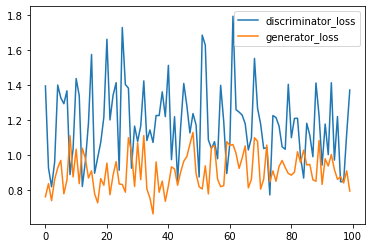

In [68]:
model = KuGAN()
model.fit(data, plot_loss=True)

In [49]:
zeroes, ones = data['Label'].value_counts()
print(f'Zeros: {zeroes} Ones: {ones}')
diff = np.abs(zeroes - ones)

Zeros: 3000 Ones: 1465


In [50]:
synthetic_data = model.synthesize(diff)
malware_data = data.append(synthetic_data)
# shuffle synthetic data with original data
# shuffled_malware_data = malware_data.sample(frac=1)
X = malware_data.drop(columns = ['Label']).copy()
y = malware_data['Label']

/tmp/ipykernel_564486/812423160.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  malware_data = data.append(synthetic_data)


In [51]:
# Build the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500, criterion='entropy')
model.fit(X, y)

RandomForestClassifier(criterion='entropy', n_estimators=500)

In [53]:
data_valid = pd.read_csv('data/Validation.csv')
data_solution = pd.read_csv('data/Solution.csv')

X_valid = data_valid.drop(columns = ['ID']).copy()
y_valid = data_solution.drop(columns = ['ID']).copy()

In [54]:
from sklearn.metrics import mean_squared_error

p_test = model.predict(X_valid)
rmse_gan = mean_squared_error(y_valid, p_test, squared=False)
print(f'RMSE: {round(rmse_gan * 100, 7)}%')

RMSE: 16.2221421%


In [55]:
delta = round(rmse_gan - rmse, 3)
print(abs(delta))

0.006
